# Importing Neccesary Libraries 

In [109]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from sklearn import preprocessing

### Reading Labels from test and train csv files

In [110]:
train=pd.read_csv('../input/lego-dataset/Train.csv')
test=pd.read_csv('../input/lego-dataset/Test.csv')

In [111]:
X=train.iloc[:,0].values
y=train.iloc[:,1].values
X_test=test.iloc[:,0].values

### Setting path to image folders  

In [112]:
train_path= '../input/lego-dataset/train/'
test_path= '../input/lego-dataset/test/'

# Doing One Hot Encoding so we get a better prediction

In [113]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
Y = np_utils.to_categorical(encoded_y)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

### Creating Image Test and Train set

In [114]:
imgs_train=[]
imgs_val=[]
imgs_test=[]
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,Y,test_size=0.20,random_state=0)
for I in X_train:
    img=cv2.imread(str(train_path)+str(I),cv2.IMREAD_GRAYSCALE)
    imgs_train.append(img)
for I in X_val:
    img=cv2.imread(str(train_path)+str(I),cv2.IMREAD_GRAYSCALE)
    imgs_val.append(img)
for I in X_test:
    img=cv2.imread(str(test_path)+str(I),cv2.IMREAD_GRAYSCALE)
    imgs_test.append(img)

# Reshaping the images

In [115]:
imgs_train=np.array(imgs_train).reshape(-1,200,200,1)
imgs_val=np.array(imgs_val).reshape(-1,200,200,1)
imgs_test=np.array(imgs_test).reshape(-1,200,200,1)
imgs_train=imgs_train/255.0
imgs_val=imgs_val/255.0
imgs_test=imgs_test/255.0

In [116]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Creating CNN model

In [141]:
model=Sequential()
model.add(Conv2D(64,(5,5),activation='relu',input_shape=(200,200,1)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(16,activation='softmax'))

#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 196, 196, 64)      1664      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 44, 44, 64)        102464    
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 30976)           

In [142]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [143]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [128]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [144]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(imgs_train)

## Training the Model on train data

In [146]:
# history = model.fit_generator(datagen.flow(imgs_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (imgs_val, y_val),
#                               verbose = 2, steps_per_epoch=imgs_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

history = model.fit(imgs_train,y_train,epochs=35)
(eval_loss, eval_accuracy) = model.evaluate(imgs_val, y_val)
print('[INFO] accuracy: {:.2f}%'.format(eval_accuracy * 100)) 
print('[INFO] Loss: {}'.format(eval_loss))

Epoch 1/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.7197 - accuracy: 0.7102
Epoch 2/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.4049 - accuracy: 0.8390
Epoch 3/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.2686 - accuracy: 0.8919
Epoch 4/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.2106 - accuracy: 0.9113
Epoch 5/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.1964 - accuracy: 0.9222
Epoch 6/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.1426 - accuracy: 0.9384
Epoch 7/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.1185 - accuracy: 0.9507
Epoch 8/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.0987 - accuracy: 0.9521
Epoch 9/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.0936 - accuracy: 0.9572
Epoch 10/35
3572/3572 [==============================] - 4s 1ms/step - loss: 0.084

# Confusion Matrix on Validation Data

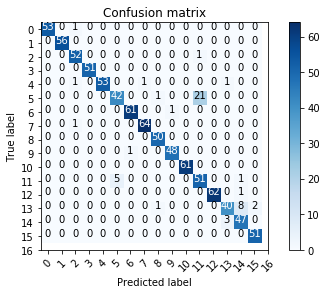

<Figure size 14400x7200 with 0 Axes>

In [153]:
from sklearn.metrics import confusion_matrix
import itertools
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.figure(figsize=(200,100))

# Predict the values from the validation dataset
Y_pred = model.predict(imgs_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(17)) 

# F1 Score for the prediction

In [158]:
from sklearn.metrics import f1_score
fScore=f1_score(Y_true, Y_pred_classes,average='weighted')*100
print('F1 Score: {:.2f}%'.format(fScore)) 

F1 Score: 94.24%


# Predicting Daa on Testset and exporting it as .csv

In [159]:
y_test=model.predict(imgs_test)
out=['category']
for i in range(y_test.shape[0]):
    for j in range(np.size(y_test[i])):
        if(y_test[i][j]>0.5):
            out.append(j+1)
ID=['name']
for i in range(np.size(X_test)):
    ID.append(X_test[i])
np.savetxt('Result.csv',[p for p in zip(ID,out)], delimiter=',',fmt='%s')